## Loading Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from warnings import filterwarnings
filterwarnings('ignore')

import pickle
import tensorflow as tf
from tensorflow import keras
import os
import math
import keras
from PIL import Image
import cv2
import pandas as pd

np.random.seed(1337)

from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Activation, Add, Concatenate, Conv2D, GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D,Input, Dense
from keras.layers import MaxPooling2D,AveragePooling2D, BatchNormalization, Lambda, DepthwiseConv2D
from keras.models import Sequential
from keras.layers import Input,merge,LSTM,Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D,ZeroPadding2D,AveragePooling2D
from keras.layers import BatchNormalization,Reshape
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy.random as npr


# Flower Species Classification

## Test Dataset Load

In [2]:
data_test=np.load('flower_species_classification/data_test.npy')
data_test=np.reshape(data_test,(300,300,3,data_test.shape[1]))
data_test=np.moveaxis(data_test, -1, 0)
print(data_test.shape)

(415, 300, 300, 3)


## Normalization

In [3]:
data_test=data_test/255

## Label Encoding

In [4]:
label_test=np.load('flower_species_classification/labels_test.npy')
t_test=np_utils.to_categorical(label_test, 10)

## Loading Best Model

In [5]:
layer_no=6
activation_function='relu'
filter_size=4
lr=0.0001
save_path='flower_species_classification/prob1_'+activation_function+'_layers'+str(layer_no)+'_filtersize'+str(filter_size)
from keras.models import load_model
final_model=load_model(save_path+'.hdf5')

2022-12-10 22:39:47.873972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 22:39:48.448075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78470 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:90:00.0, compute capability: 8.0


## Evaluation and Prediction on Test Set

In [6]:
final_model.evaluate(data_test,t_test,batch_size=1,verbose=1)
prediction=final_model.predict(data_test,batch_size=1)
prediction_labels=np.argmax(prediction,axis=1)

2022-12-10 22:39:50.661313: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2022-12-10 22:39:51.557998: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2022-12-10 22:39:51.662121: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


  7/415 [..............................] - ETA: 7s - loss: 1.7877 - accuracy: 0.7143 

2022-12-10 22:39:52.490886: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


415/415 [==============================] - 10s 19ms/step - loss: 0.5108 - accuracy: 0.8723


## Classification Report on Test Set

In [7]:
print(classification_report(label_test,prediction_labels))

              precision    recall  f1-score   support

         0.0       0.89      0.88      0.88        48
         1.0       0.95      0.89      0.92        44
         2.0       0.76      0.70      0.73        46
         3.0       0.92      0.97      0.95        36
         4.0       0.81      0.87      0.84        45
         5.0       0.88      0.90      0.89        40
         6.0       0.84      0.95      0.89        43
         7.0       0.83      0.95      0.89        37
         8.0       0.91      0.91      0.91        32
         9.0       0.97      0.77      0.86        44

    accuracy                           0.87       415
   macro avg       0.88      0.88      0.87       415
weighted avg       0.88      0.87      0.87       415



## Confusion Matrix on Test Set

Confusion matrix, without normalization


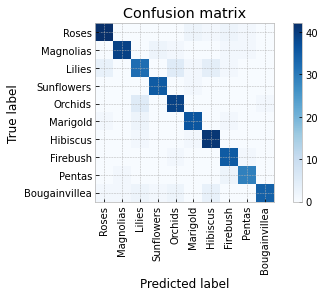

In [8]:
def plot_confusion_matrix(cm, classes,
                              normalize=True,include_values=True,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues,values_format=None):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']
cnf_matrix = (confusion_matrix(label_test,prediction_labels))

plot_confusion_matrix(cnf_matrix,classes=class_names,
                          normalize=False,include_values=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,values_format=None)

## Car Detection

Fuction of calculating IOU (This code is taken from open-source platform)

In [9]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

## Loading Test images, Resizing and Normalizing

In [10]:
size_correction=.60
bbox = pd.read_csv('car_detection_dataset/test_bounding_boxes_no_multiple_car.csv')

N = len(bbox) # no. of test samples
for i in range(N): 
    filename='car_detection_dataset/testing_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    
    if i==0:
        X_test = image_col
    else:
        X_test = np.hstack((X_test, image_col))

X_test = X_test.T

t_test = bbox.drop('image', axis=1).round().to_numpy().astype(int)
print( "Shape of test dataset:", X_test.shape)
print( "Shape of test labels:", t_test.shape)

(Ny,Nx,Nz) = image.shape
print( "Shape of an image:", Nx, Ny, Nz)
print( "Shape of training labels:", t_test.shape)

X_test=np.reshape(X_test,(X_test.shape[0],Nx,Ny,Nz))
from skimage.feature import hog

Nx_resize=int(380*size_correction)
Ny_resize=int(676*size_correction)
X_test_resize=np.zeros((X_test.shape[0],Nx_resize,Ny_resize,3))
for i in range(X_test.shape[0]):
    #print(i)
    X_test_resize[i,:,:,0]=cv2.resize(X_test[i,:,:,0],(Ny_resize,Nx_resize))
    X_test_resize[i,:,:,1]=cv2.resize(X_test[i,:,:,1],(Ny_resize,Nx_resize))
    X_test_resize[i,:,:,2]=cv2.resize(X_test[i,:,:,2],(Ny_resize,Nx_resize))

X_test=np.array(X_test_resize)
X_test_resize=None
X_test=np.reshape(X_test,(X_test.shape[0],Nx_resize,Ny_resize,3))
X_test = X_test/255

t_test = bbox.drop('image', axis=1).to_numpy().astype('float32')
t_test_normalized=t_test.copy()
t_test_normalized[:,0] = t_test[:,0]/Nx
t_test_normalized[:,1] = t_test[:,1]/Ny
t_test_normalized[:,2] = t_test[:,2]/Nx
t_test_normalized[:,3] = t_test[:,3]/Ny

Shape of test dataset: (164, 770640)
Shape of test labels: (164, 4)
Shape of an image: 676 380 3
Shape of training labels: (164, 4)


## Loading best model1 and prediction of ymin and ymax

In [11]:
lr=0.001
layer_no=6
activation_function='relu'
filter_size1=3
filter_size2=3
stride1=2
stride2=2
batch_size=32
save_path='new_prob2_'+activation_function+'_layers'+str(layer_no)+'_lr_'+str(lr)+'_stride_'+str(stride1)+'_bz_'+str(batch_size)
from keras.models import load_model
final_model=load_model(save_path+'.hdf5')

final_model.evaluate(X_test,t_test_normalized[:,1:4:2],batch_size=1,verbose=1)
prediction_test=final_model.predict(X_test,batch_size=1,verbose=1)

prediction_test_unscaled=np.zeros((prediction_test.shape[0],4))
prediction_test_unscaled[:,1]=prediction_test[:,0]*Ny
prediction_test_unscaled[:,3]=prediction_test[:,1]*Ny
prediction_test_unscaled = prediction_test_unscaled.round()

for i in range(len(prediction_test)):
    if prediction_test[i,0]+prediction_test[i,1] < 0.4:
        prediction_test_unscaled[i,1]=0
        prediction_test_unscaled[i,3]=0

164/164 [==============================] - 0s 2ms/step


## Loading HOG images, pre-processing and prediction

In [12]:
X_test_hog=np.load('X_test_hog.npy')
t_test=np.load('t_test.npy')
t_test_normalized=np.load('t_test_normalized.npy')

for i in range(X_test.shape[0]):    
    X_test_hog[i,0:int(prediction_test_unscaled[i,1]*size_correction),:]=0
    X_test_hog[i,int(prediction_test_unscaled[i,3]*size_correction):,:]=0

layer_no=6
activation_function='relu'
filter_size1=3
filter_size2=3
stride1=2
stride2=2
lr=0.001
batch_size=16
save_path='new_prob2_x_dir_'+activation_function+'_layers'+str(layer_no)+'_lr_'+str(lr)+'_stride_'+str(stride1)+'_bz'+str(batch_size)
from keras.models import load_model
final_model2=load_model(save_path+'.hdf5')

prediction_test=final_model2.predict(X_test_hog,batch_size=1)

prediction_test_unscaled[:,0]=prediction_test[:,0]*Nx
prediction_test_unscaled[:,2]=prediction_test[:,1]*Nx
prediction_test_unscaled = prediction_test_unscaled.round()


## Post Processing on Test Set 

In [13]:
for i in range(X_test.shape[0]):
    if ((prediction_test_unscaled[i,1] + prediction_test_unscaled[i,3]) < 100):
        prediction_test_unscaled[i,0]=0
        prediction_test_unscaled[i,2]=0
t_test=t_test.round()

## Calculating IOU score on validation set

In [14]:
print('Test Performance')
iou_score_list=[]
for i in range(X_test.shape[0]):
    iou_score = bb_intersection_over_union(t_test[i], prediction_test_unscaled[i])
    iou_score_list.append(iou_score)
print(sum(iou_score_list)/X_test.shape[0])

Test Performance
0.5486204320597923


## Visualizing ground truth and prediction on test set

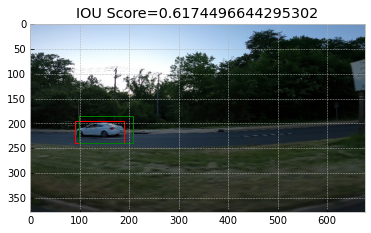

In [15]:
import matplotlib.patches as patches

import cv2
idx=6
bbox = pd.read_csv('car_detection_dataset/test_bounding_boxes_no_multiple_car.csv')
for i in range(idx,idx+1): 
    filename='car_detection_dataset/testing_images/'+bbox['image'][i]
    im = np.array(Image.open(filename))

fig, ax = plt.subplots()

ax.imshow(im)

rect1 = patches.Rectangle((int(t_test[idx,0]), int(t_test[idx,1])), int(t_test[idx,2])-int(t_test[idx,0]), int(t_test[idx,3])-int(t_test[idx,1]), linewidth=1, edgecolor='r', facecolor='none')
rect2 = patches.Rectangle((int(prediction_test_unscaled[idx,0]), int(prediction_test_unscaled[idx,1])), int(prediction_test_unscaled[idx,2])-int(prediction_test_unscaled[idx,0]), int(prediction_test_unscaled[idx,3])-int(prediction_test_unscaled[idx,1]), linewidth=1, edgecolor='g', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.title('IOU Score=' + str(iou_score_list[idx]))
plt.show()


## Evaluation from point of view of a classification problem

In [23]:
y_true=[]
for i in range(X_test.shape[0]):
    if np.sum(t_test[i])==0:
        y_true.append(0)
    else:
        y_true.append(1)
        
y_pred=[]
for i in range(X_test.shape[0]):
    if np.sum(prediction_test_unscaled[i])==0:
        y_pred.append(0)
    else:
        y_pred.append(1)
class_names = ['Car Absent','Car Present']
       
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

  Car Absent       0.81      0.93      0.86        89
 Car Present       0.90      0.73      0.81        75

    accuracy                           0.84       164
   macro avg       0.85      0.83      0.84       164
weighted avg       0.85      0.84      0.84       164



## Confusion Matrix of Car Detection

Confusion matrix, without normalization


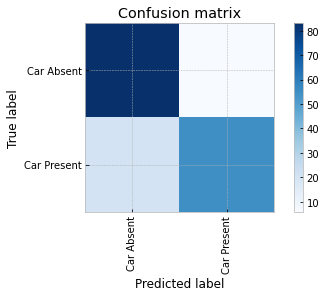

In [21]:
def plot_confusion_matrix(cm, classes,
                              normalize=True,include_values=True,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues,values_format=None):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Car Absent','Car Present']
cnf_matrix = (confusion_matrix(y_true,y_pred))

plot_confusion_matrix(cnf_matrix,classes=class_names,
                          normalize=False,include_values=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,values_format=None)